## Predicting House Prices using XGBoost

In [3]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.cross_validation import KFold, train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# read the data
x_train = np.loadtxt('data/x_train_cleaned.txt', delimiter=',')
x_test = np.loadtxt('data/x_test_cleaned.txt', delimiter=',')
y_train_log = np.loadtxt('data/y_train_log.txt', delimiter=',')

In [5]:
# formatting for xgb
dtrain = xgb.DMatrix(x_train, label=y_train_log)
dtest = xgb.DMatrix(x_test)

In [6]:
# set initial parameters
xgb1 = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread = 4,
 seed=0)

xgb_param = xgb1.get_xgb_params()

### 1. Set a large learning rate and tune n_estimators 
using the default learning rate of 0.2 to tune the other parameters

In [7]:
# use 5-fold CV
cv_folds = 5
# stop when perfomance does not improve for 50 rounds
early_stopping_rounds = 50

# tune number of trees
cvresult = xgb.cv(xgb_param, dtrain, num_boost_round=xgb_param['n_estimators'], nfold=cv_folds,
    metrics='rmse', early_stopping_rounds=early_stopping_rounds)

print "The model requires {} estimators.". format(cvresult.shape[0])
# update the parameter
n_estimators = cvresult.shape[0]
xgb_param['n_estimators'] = n_estimators
# performance
print "The rmse is ", cvresult['test-rmse-mean'][n_estimators-1]

The model requires 391 estimators.
The rmse is  0.1203396


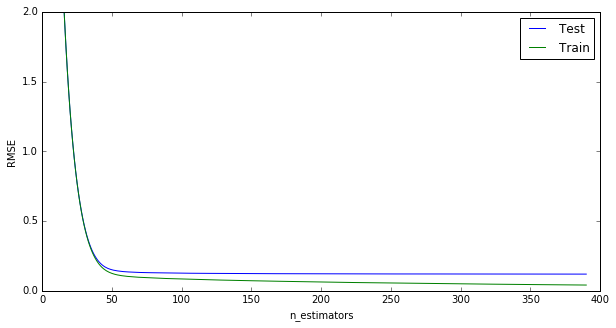

In [8]:
# add a figure of the RMSE change over n_estimators
fig = plt.figure(figsize = (10, 5))
ax1 = fig.add_subplot(111)
ax1.plot(range(n_estimators), cvresult['test-rmse-mean'].values, label = "Test")
ax1.plot(range(n_estimators), cvresult['train-rmse-mean'].values, label = "Train")

ax1.set_ylim([0, 2])
plt.ylabel("RMSE")
plt.xlabel("n_estimators")
plt.legend()

In [9]:
### Function to tune two parameters of XGBoost
## Input: name and choices of the two parameters, the model and training data
## Output: best score and the two parameters
def two_param_tuning (param_name_1, list_1, param_name_2, list_2, xgb_param, dtrain):
    best_score = 10e4
    best_param_1 = -1
    best_param_2 = -1

    for param_1 in list_1:
        xgb_param[param_name_1] = param_1
        
        for param_2 in list_2:
            xgb_param[param_name_2] = param_2

            cvresult = xgb.cv(xgb_param, dtrain, num_boost_round=xgb_param['n_estimators'], nfold=cv_folds,
                              metrics='rmse')
            score = cvresult['test-rmse-mean'][xgb_param['n_estimators']-1]

            if score < best_score:
                best_score = score
                best_param_1 = param_1
                best_param_2 = param_2
    
    return best_score, best_param_1, best_param_2


### Function to tune one parameter of XGBoost
## Input: name and choices of the parameter, the model and training data
## Output: best score and the parameter
def one_param_tuning (param_name_1, list_1, xgb_param, dtrain):
    best_score = 10e4
    best_param_1 = -1

    for param_1 in list_1:
        xgb_param[param_name_1] = param_1

        cvresult = xgb.cv(xgb_param, dtrain, num_boost_round=xgb_param['n_estimators'], nfold=cv_folds,
                          metrics='rmse')
        score = cvresult['test-rmse-mean'][xgb_param['n_estimators']-1]

        if score < best_score:
            best_score = score
            best_param_1 = param_1
    
    return best_score, best_param_1

### 2. Tune max_depth and min_child_weight
Preventing overfitting

In [10]:
# options
max_depth_list = range(3, 10, 2)
min_child_weight_list = range(1, 6, 2)

best_score, best_max_depth, best_min_child_weight = two_param_tuning('max_depth', max_depth_list, 
                                                                     'min_child_weight', min_child_weight_list,
                                                                     xgb_param, dtrain)

print "The best max_depth is ", best_max_depth
print "The best min_child_weight is ", best_min_child_weight
print "The rmse is ", best_score

The best max_depth is  3
The best min_child_weight is  1
The rmse is  0.1203396


Fine tuning around the selected values

In [11]:
# fine tune around the best parameter values
max_depth_list = range(2, 5, 1)
min_child_weight_list = range(1, 4, 1)

best_score, best_max_depth, best_min_child_weight = two_param_tuning('max_depth', max_depth_list, 
                                                                     'min_child_weight', min_child_weight_list,
                                                                     xgb_param, dtrain)

print "The best max_depth is ", best_max_depth
print "The best min_child_weight is ", best_min_child_weight
print "The rmse is ", best_score

The best max_depth is  3
The best min_child_weight is  1
The rmse is  0.1203396


In [12]:
# update the parameters
xgb_param['max_depth'] = best_max_depth
xgb_param['min_child_weight'] = best_min_child_weight

### 3. Tune gamma
related to loss function

In [13]:
gamma_list = [i/100.0 for i in range(0,5)]

best_score, best_gamma = one_param_tuning('gamma', gamma_list, xgb_param, dtrain)

print "The best gamma is ", best_gamma
print "The rmse is ", best_score

The best gamma is  0.0
The rmse is  0.1203396


In [14]:
# update the parameter
xgb_param['gamma'] = best_gamma

### 4. Tune subsample and colsample_bytree

In [15]:
subsample_list = [i/10.0 for i in range(6,10)]
colsample_bytree_list = [i/10.0 for i in range(6,10)]

best_score, best_subsample, best_colsample_bytree = two_param_tuning('subsample', subsample_list, 'colsample_bytree', colsample_bytree_list,
                                              xgb_param, dtrain)

print "The best subsample is ", best_subsample
print "The best colsample_bytree is ", best_colsample_bytree
print "The rmse is ", best_score

The best subsample is  0.8
The best colsample_bytree is  0.8
The rmse is  0.1203396


In [16]:
# update the parameters
xgb_param['subsample'] = best_subsample
xgb_param['colsample_bytree'] = best_colsample_bytree

### 5. Fine tuning
Using small learning rate and large number of estimators

In [17]:
xgb_param['learning_rate'] = 0.01
xgb_param['n_estimators'] = 5000

early_stopping_rounds = 50

cvresult = xgb.cv(xgb_param, dtrain, num_boost_round=xgb_param['n_estimators'], nfold=cv_folds,
    metrics='rmse', early_stopping_rounds=early_stopping_rounds)

print "The model requires {} estimators.". format(cvresult.shape[0])
# update the parameter
n_estimators = cvresult.shape[0]
xgb_param['n_estimators'] = n_estimators
# performance
print "The rmse is ", cvresult['test-rmse-mean'][n_estimators-1]

The model requires 2427 estimators.
The rmse is  0.1188416


### Final XGBoost model

In [18]:
# final parameters
xgb_param

{'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bytree': 0.8,
 'gamma': 0.0,
 'learning_rate': 0.01,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 2427,
 'nthread': 4,
 'objective': 'reg:linear',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0,
 'silent': 1,
 'subsample': 0.8}

In [19]:
# the final model
xgb1 = xgb.XGBRegressor(
 learning_rate = 0.01,
 n_estimators = 2427,
 subsample = 0.8,
 colsample_bytree = 0.8,
 objective= 'reg:linear',
 max_depth = 3,
 min_child_weight = 1,
 nthread = 4,
 seed=0)

In [20]:
# fit the model
xgb1.fit(x_train, y_train_log)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=2427, nthread=4,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8)

In [21]:
# prediction
y_pred = xgb1.predict(x_test)

# convert to original scale and save
submission = pd.read_csv('data/sample_submission.csv')
submission['SalePrice'] = np.exp(y_pred)
submission.to_csv('results/xgb.csv', sep = ',', index=False)

Predict on training data using k-fold for ensemble purpose

In [24]:
y_pred_2 = cross_val_predict(xgb1, x_train, y_train_log, cv = 5)

# remember to convert to original scale
xgb_train = pd.DataFrame(np.exp(y_pred_2))
xgb_train.to_csv('results/xgb_train.csv', sep = ',', index=False, header = None)